# DGEA, analysis & plotting for Mesodermal branch

# Notebook setup

In [3]:
import os
os.chdir('/local/workdir/dwm269/scCardiacOrganoid/')

In [6]:
from itertools import chain
from itertools import product
import numpy as np
import anndata as ad
import pandas as pd

import scanpy as sc
import scanpy.external as sce


import seaborn as sns
# from scipy import io
# from scipy import sparse

import matplotlib.pyplot as plt
import random

from adjustText import adjust_text

In [7]:
from scripts.py.utils import *
from scripts.py.plots import *

# Load data/metadata

In [8]:

meta = pd.read_csv("resources/metadata.csv")
meta = meta.loc[meta["source"]=="Hoang et al",]
meta = meta.loc[meta["include"],]
meta.index = list(range(0, len(meta)))
meta

,sample,include,data.dir,pattern,pattern_int,timepoint,time_int,cell_line,source,soupx,soupx_rho_GeneFull
0,D0_600um,True,/workdir/dwm269/scCardiacOrganoid/data/STARsol...,600um,600.0,D0,0,GCaMP6f hiPSCs,Hoang et al,False,NaN
1,D1_600um,True,/workdir/dwm269/scCardiacOrganoid/data/STARsol...,600um,600.0,D1,1,GCaMP6f hiPSCs,Hoang et al,False,NaN
2,D4_200um,True,/workdir/dwm269/scCardiacOrganoid/data/STARsol...,200um,200.0,D4,4,GCaMP6f hiPSCs,Hoang et al,True,0.076
3,D4_600um,True,/workdir/dwm269/scCardiacOrganoid/data/STARsol...,600um,600.0,D4,4,GCaMP6f hiPSCs,Hoang et al,True,0.070
4,D4_1000um,True,/workdir/dwm269/scCardiacOrganoid/data/STARsol...,1000um,1000.0,D4,4,GCaMP6f hiPSCs,Hoang et al,True,0.140
5,D6_600um,True,/workdir/dwm269/scCardiacOrganoid/data/STARsol...,600um,600.0,D6,6,GCaMP6f hiPSCs,Hoang et al,True,0.029
6,D8_600um,True,/workdir/dwm269/scCardiacOrganoid/data/STARsol...,600um,600.0,D8,8,GCaMP6f hiPSCs,Hoang et al,True,0.015
7,D12_600um,True,/workdir/dwm269/scCardiacOrganoid/data/STARsol...,600um,600.0,D12,12,GCaMP6f hiPSCs,Hoang et al,True,0.017
8,D21_200um_B,True,/workdir/dwm269/scCardiacOrganoid/data/STARsol...,200um,200.0,D21,21,GCaMP6f hiPSCs,Hoang et al,True,0.011
9,D21_600um,True,/workdir/dwm269/scCardiacOrganoid/data/STARsol...,600um,600.0,D21,21,GCaMP6f hiPSCs,Hoang et al,True,0.039


In [9]:
adata = sc.read_h5ad(
    filename="data/pyobjs/mesoderm_2a.h5ad"
)

# DGEA between cluster pairs

In [10]:
sc.pp.log1p(adata)

/home/dwm269/miniconda3/envs/pyRNA6/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(X, out=X)
/home/dwm269/miniconda3/envs/pyRNA6/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


In [11]:
sc.tl.rank_genes_groups(
    adata,
    groupby=f"subclusters_{0.8}_anno", 
    groups = ['Cardiomyocytes (NKX2.5+)','Cardiomyocytes (ISL1+)'],
    method='wilcoxon',
    layer='data',
    key_added="cardiomyocytes_DGEA",
    pts=True
)

In [12]:
# sc.tl.filter_rank_genes_groups(
#     adata, 
#     min_fold_change=3
# )

In [13]:
export_dgea_to_csv(
    adata=adata,
    dgea_name='cardiomyocytes_DGEA',
    n_features=100,
    axis=0,
    csv_out='resources/dgea/mesoderm/scco_v1c_cardiomyocytes.csv'
)

In [14]:

def draw_volcano_plot(adata, groupby, groups=None, min_abs_log2foldchange=1, min_neglog10_pvalue=1.3, top_n_genes=10, xlabel="log2 fold change", ylabel="-log10 p-value", de_key="rank_genes_groups"):
    if de_key not in adata.uns:
        raise ValueError(f"Please run differential expression analysis and store the results in adata.uns['{de_key}'].")
    
    if groups is None:
        groups = adata.obs[groupby].cat.categories

    # Extract gene ranking data
    gene_ranking = adata.uns[de_key]
    
    # Create a DataFrame
    dfs = []
    for group in groups:
        scores = gene_ranking["scores"][group]
        logfoldchanges = gene_ranking["logfoldchanges"][group]
        names = gene_ranking["names"][group]

        df = pd.DataFrame({"Gene": names, "Score": scores, "Log2FoldChange": logfoldchanges, "Group": group})
        dfs.append(df)

    volcano_df = pd.concat(dfs, ignore_index=True)
    
    # Calculate -log10 p-value
    volcano_df["-Log10Pvalue"] = -volcano_df["Score"].apply(pd.np.log10)

    # Filter genes based on minimum absolute log fold change and minimum -log10(p-value)
    volcano_df = volcano_df[(volcano_df["Log2FoldChange"].abs() >= min_abs_log2foldchange) & (volcano_df["-Log10Pvalue"] >= min_neglog10_pvalue)]

    # Calculate the combined score
    volcano_df["CombinedScore"] = volcano_df["Log2FoldChange"] * volcano_df["-Log10Pvalue"]

    # Plot volcano plot
    plt.figure(figsize=(12, 8))
    ax = sns.scatterplot(data=volcano_df, x="Log2FoldChange", y="-Log10Pvalue", hue="Group", alpha=0.8)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # plt.title(f"Volcano plot for groups: {', '.join(groups)}")

    # Label top genes based on the combined score
    for _, row in volcano_df.nlargest(top_n_genes, "CombinedScore").iterrows():
        ax.text(row["Log2FoldChange"], row["-Log10Pvalue"], row["Gene"], fontsize=10, ha="center")

    plt.show()


In [16]:
def draw_volcano_plot(
        adata, 
        groupby, 
        groups=None, 
        min_abs_log2foldchange=1, 
        min_neglog10_pvalue=1.3, 
        top_n_genes=10, 
        xlabel="log2 fold change", 
        ylabel="-log10 p-value", 
        de_key="rank_genes_groups", 
        name_filter_pattern="RP"
):
    if de_key not in adata.uns:
        raise ValueError(f"Please run differential expression analysis and store the results in adata.uns['{de_key}'].")
    
    if groups is None:
        groups = adata.obs[groupby].cat.categories

    # Extract gene ranking data
    gene_ranking = adata.uns[de_key]
    
    # Create a DataFrame
    dfs = []
    for group in groups:
        scores = gene_ranking["scores"][group]
        logfoldchanges = gene_ranking["logfoldchanges"][group]
        names = gene_ranking["names"][group]

        df = pd.DataFrame({"Gene": names, "Score": scores, "Log2FoldChange": logfoldchanges, "Group": group})
        dfs.append(df)

    volcano_df = pd.concat(dfs, ignore_index=True)
    
    # Calculate -log10 p-value
    volcano_df["-Log10Pvalue"] = -volcano_df["Score"].apply(pd.np.log10)

    # Filter genes based on minimum absolute log fold change and minimum -log10(p-value)
    volcano_df = volcano_df[(volcano_df["Log2FoldChange"].abs() >= min_abs_log2foldchange) & (volcano_df["-Log10Pvalue"] >= min_neglog10_pvalue)]

    # Calculate the combined score
    volcano_df["CombinedScore"] = volcano_df["Log2FoldChange"] * volcano_df["-Log10Pvalue"]

    # Filter genes based on name pattern
    volcano_df = volcano_df[~volcano_df["Gene"].str.contains(name_filter_pattern)]  # Add ~ to exclude genes containing the pattern

    # Plot volcano plot
    plt.figure(figsize=(12, 8))
    ax = sns.scatterplot(data=volcano_df, x="Log2FoldChange", y="-Log10Pvalue", hue="Group", alpha=0.8)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"Volcano plot for groups: {', '.join(groups)}")

    # Label top genes based on the combined score and adjust text to prevent overlap
    top_genes = volcano_df.nlargest(top_n_genes, "CombinedScore")
    texts = []
    for _, row in top_genes.iterrows():
        texts.append(ax.text(row["Log2FoldChange"], row["-Log10Pvalue"], row["Gene"], fontsize=10, ha="center"))
        ax.plot([row["Log2FoldChange"], row["Log2FoldChange"]], [row["-Log10Pvalue"], row["-Log10Pvalue"]], linestyle='-', linewidth=0.5, color='black')

    adjust_text(texts)

    plt.show()


/tmp/ipykernel_2066312/4206865184.py:35: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  volcano_df["-Log10Pvalue"] = -volcano_df["Score"].apply(pd.np.log10)


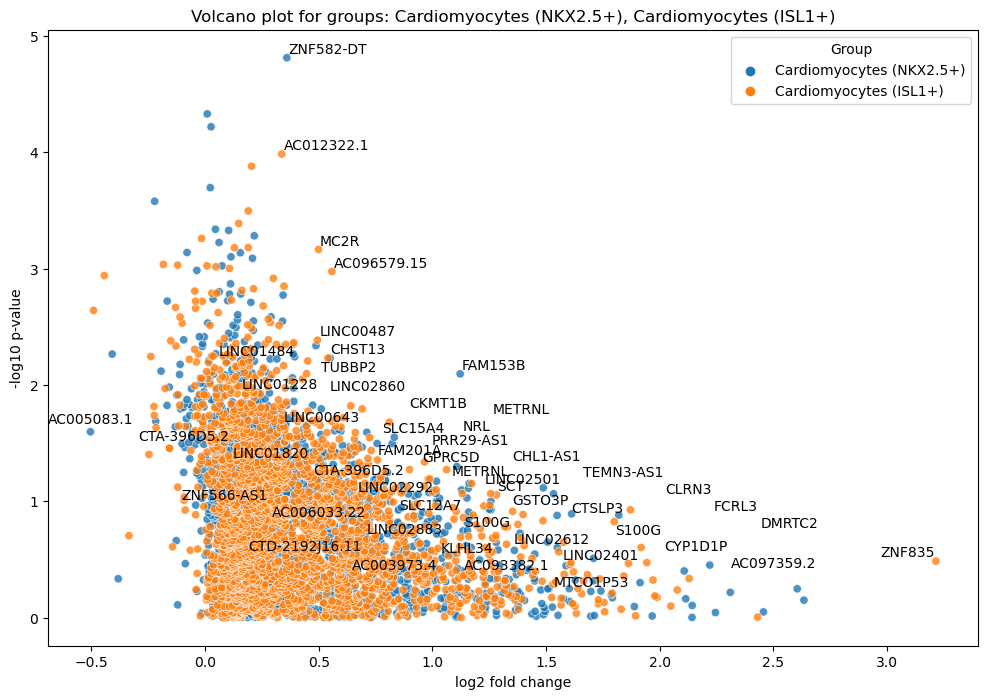

In [17]:
draw_volcano_plot(
    adata, 
    groupby=f"subclusters_{0.8}_anno", 
    groups = ['Cardiomyocytes (NKX2.5+)','Cardiomyocytes (ISL1+)'],
    de_key="cardiomyocytes_DGEA",
    min_abs_log2foldchange=0, 
    min_neglog10_pvalue=0,
    top_n_genes=50
)